In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

sys.path.insert(0, "../")

import warnings
warnings.filterwarnings('ignore')

from michael import janet

2023-01-15 16:23:21.429542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

In [3]:
index = uni[uni.source_id == int(38329666836450304)].index[0]

Already have data downloaded for Gaia ID 38329666836450304.


Running pixels in aperture: 100%|████████████| 300/300 [00:02<00:00, 124.82it/s]


### Running Simple Astropy Lomb-Scargle on Sector 42-44 on star 38329666836450304 ###
### Completed Simple Astropy Lomb-Scargle for Sector 42-44 on star 38329666836450304 ###
### Running Wavelet Estimation for Sector 42-44 on star 38329666836450304 ###


100%|███████████████████████████████████████| 2288/2288 [04:58<00:00,  7.66it/s]


### Completed Wavelet Estimation for Sector 42-44 on star 38329666836450304 ###
### Running Composite ACF estimation for Sector 42-44 on star 38329666836450304 ###
### Completed Composite ACF estimation for Sector 42-44 on star 38329666836450304 ###
### Running ACF Estimation on star 38329666836450304 ###
### Completed ACF Estimation for Sector 42-44 on star 38329666836450304 ###


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


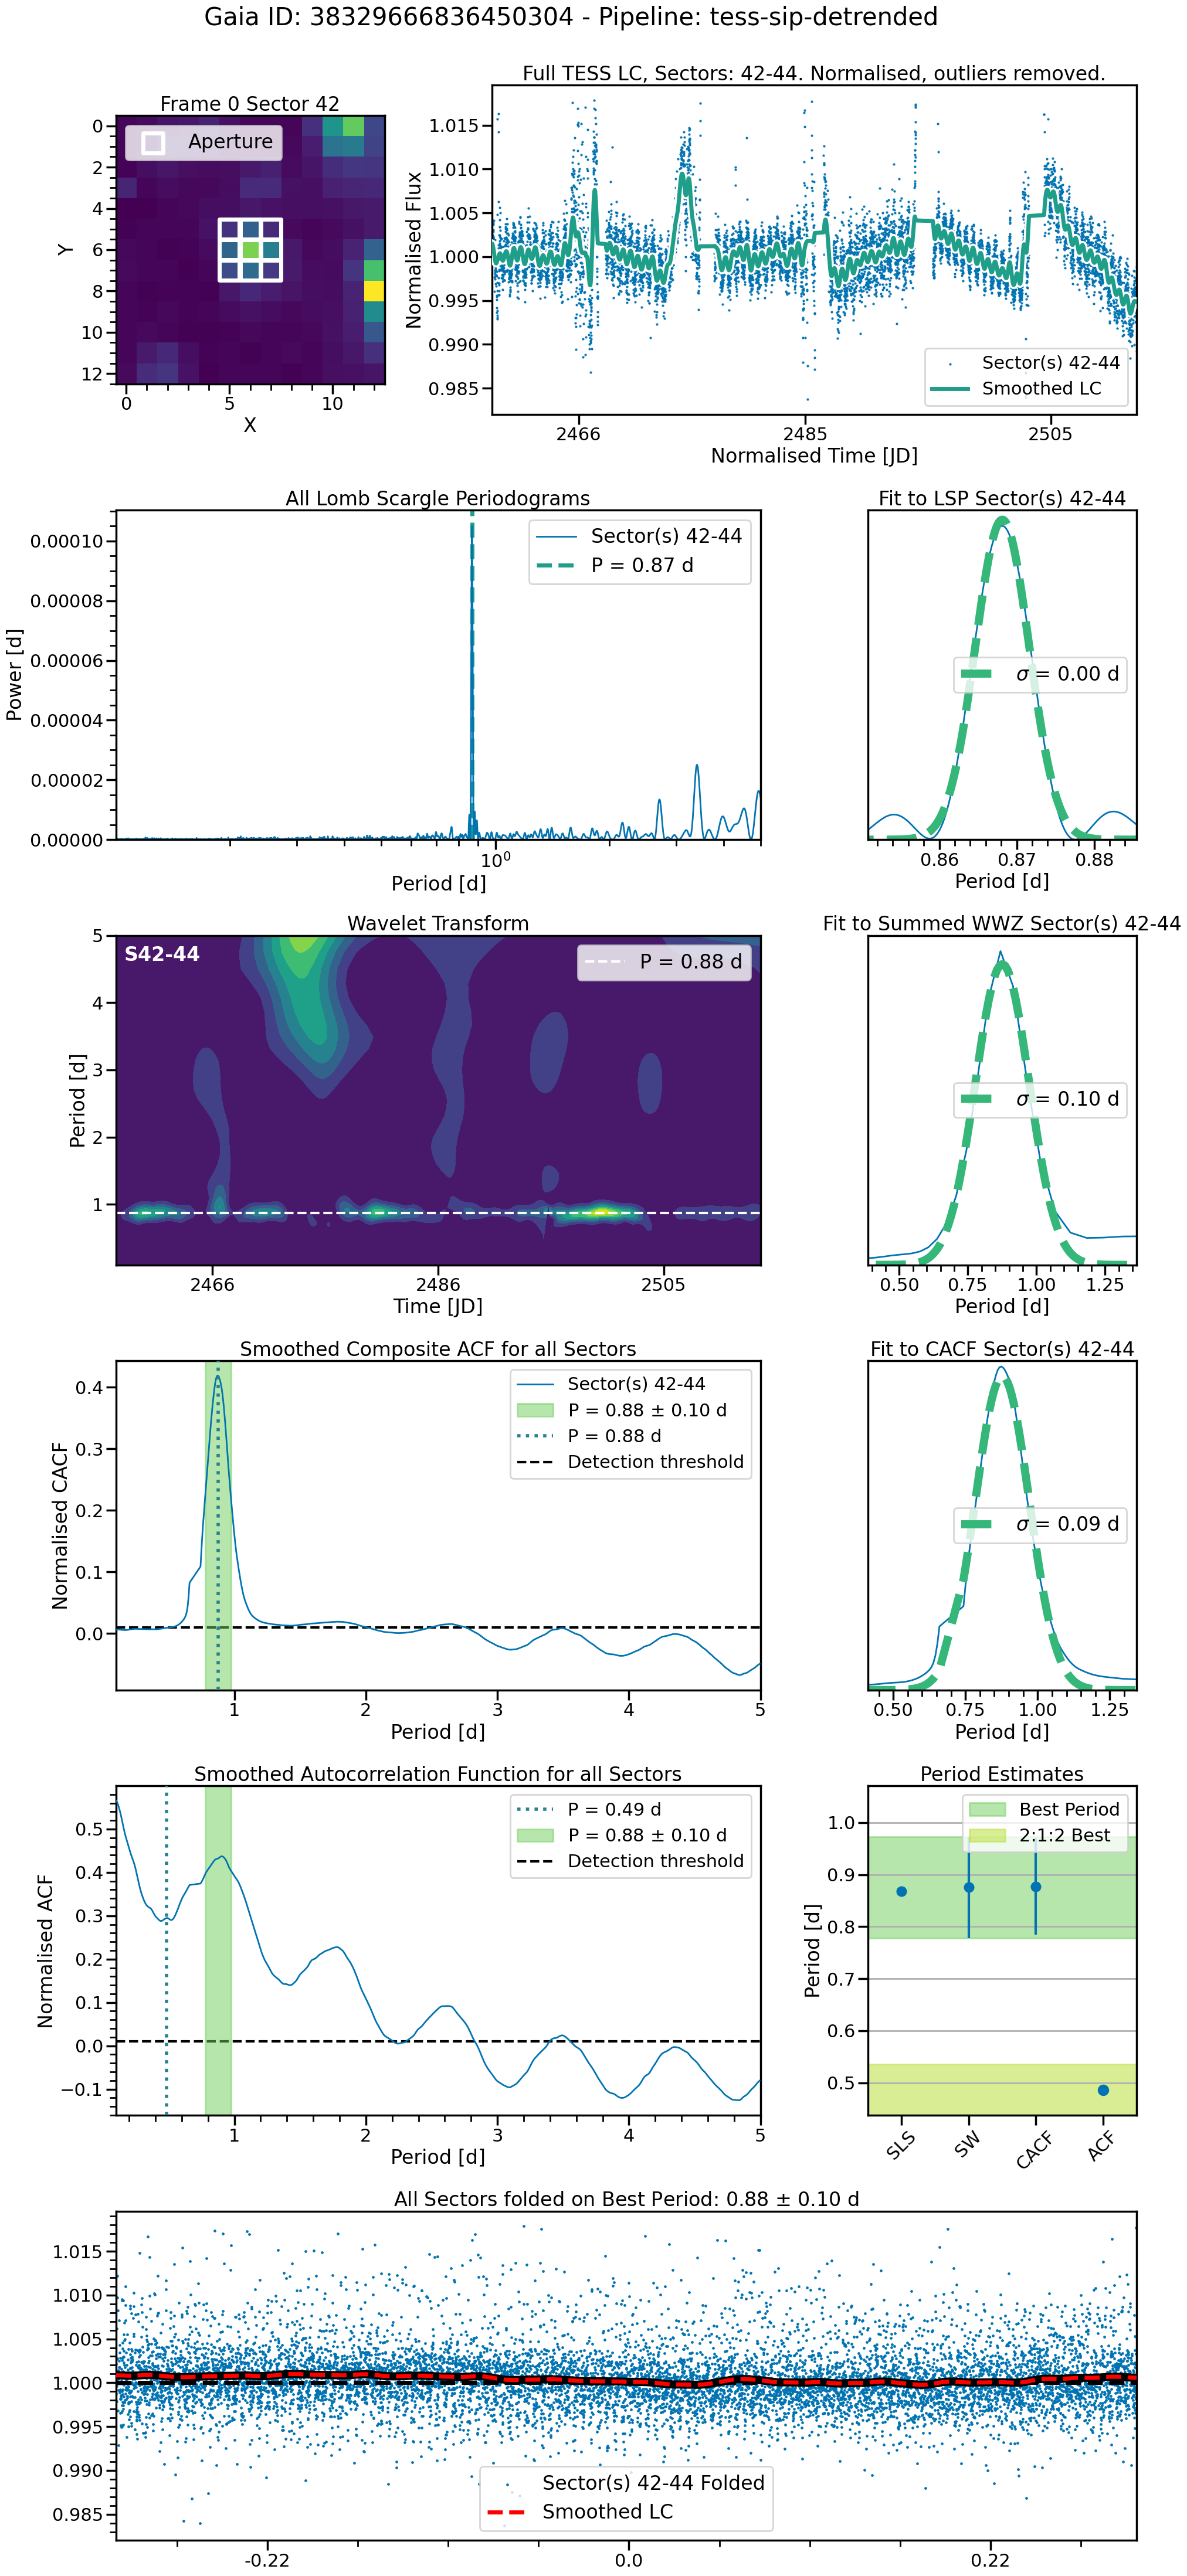

In [4]:
for method in ['tess-sip-detrended']:#'eleanor', 'eleanor-corner','eleanor-pca', 'unpopular','tess-sip']:
    j = janet.boot(uni, index=index, pipeline = method)
    j.prepare_data()
    j.get_rotation(period_range=(0.1, 5))
    j.validate_rotation()
    j.view()
    plt.show()

In [5]:
list(j.void)

['datum_5',
 'clc_5',
 'rawlc_5',
 'pcalc_5',
 'cornlc_5',
 'datum_32',
 'clc_32',
 'rawlc_32',
 'pcalc_32',
 'cornlc_32',
 'datum_42',
 'clc_42',
 'rawlc_42',
 'pcalc_42',
 'cornlc_42',
 'datum_43',
 'clc_43',
 'rawlc_43',
 'pcalc_43',
 'cornlc_43',
 'datum_44',
 'clc_44',
 'rawlc_44',
 'pcalc_44',
 'cornlc_44',
 'clc_42-44',
 'rawlc_42-44',
 'pcalc_42-44',
 'cornlc_42-44',
 'r_42-44',
 'rlc_42-44',
 'rdtlc_42-44',
 'pg_42-44',
 'p_42-44',
 'P_42-44',
 'popt_42-44',
 '42-44_wt',
 '42-44_wwz',
 '42-44_wwa',
 '42-44_wavelet_popt',
 '42-44_cacf_popt',
 '42-44_vizacf',
 '42-44_acflc',
 '42-44_cacf',
 '42-44_cacfsmoo',
 '42-44_cpeaks',
 '42-44_acfsmoo',
 '42-44_peaks']

In [6]:
j.results

,SLS,e_SLS,h_SLS,f_SLS,SW,e_SW,h_SW,CACF,e_CACF,h_CACF,...,f_p2p_ACF,s_SLS,s_SW,s_CACF,s_ACF,f_overall,overall,e_overall,p2p_overall,method_overall
42-44,0.868141,0.00347,0.000107,0.0,0.875412,0.097853,0.958655,0.877601,0.093027,0.406294,...,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
best,0.868141,0.00347,0.000107,0.0,0.875412,0.097853,0.958655,0.877601,0.093027,0.406294,...,NaN,42-44,42-44,42-44,42-44,20,0.875412,0.097853,0.001239,SW


In [7]:
sys.exit()

SystemExit: 